# **Approach to Reducing Churn Rate**

Creating 4 Clusters using K-Mean Model.

This will help us in Customer Segmentation.

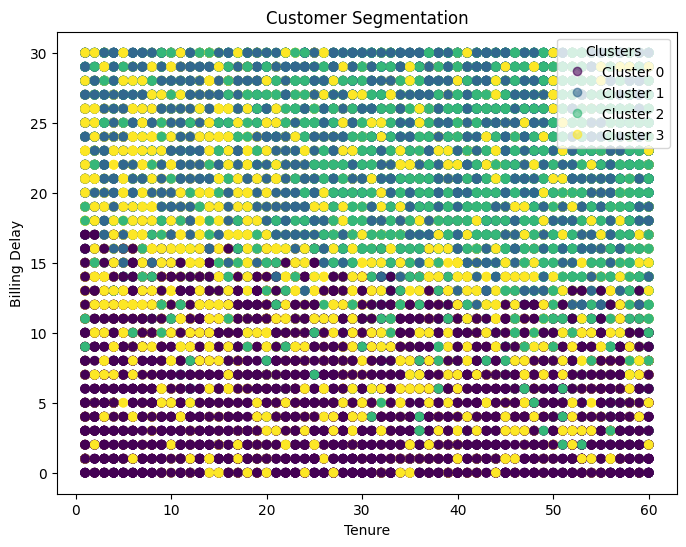

In [ ]:
# Importing libraries
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Loading the Dataset
data = pd.read_csv("/SS2025Dataset.csv")

# Scaling the data on 6 features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Tenure', 'ServiceUsageRate', 'SupportCalls','BillingDelay', 'TotalExpenditure', 'RecentActivity']])

# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# A bivariate scatter-plot based on "Tenure" and "BillingDelay"
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data['Tenure'], data['BillingDelay'], c=data['Cluster'], cmap='viridis', alpha=0.6)

legend_labels = [f"Cluster {i}" for i in range(len(set(data['Cluster'])))]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters", loc="upper right")

# Visualizing clusters
plt.scatter(data['Tenure'], data['BillingDelay'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Tenure')
plt.ylabel('Billing Delay')
plt.title('Customer Segmentation')
plt.show()


Clusters [0,1,2,3] are created.

In [ ]:
print(data.head())  # Cluster Column is added in the Dataset
print(data['Cluster'].value_counts()) # Cluster-wise Distribution

   UserID  CustomerAge     Sex  Tenure  ServiceUsageRate  SupportCalls  \
0       1           55    Male      20                24             4   
1       2           28    Male      27                30             4   
2       3           65  Female      60                17             7   
3       4           53    Male      47                16             8   
4       5           32    Male      56                 5             7   

   BillingDelay  PlanType AgreementDuration  TotalExpenditure  RecentActivity  \
0             6  Standard           Monthly               635              25   
1             5   Premium         Quarterly               631              10   
2            16   Premium         Quarterly               314               1   
3             7   Premium            Annual               527              13   
4            15   Premium            Annual               236              25   

   Churn  Cluster  
0      0        3  
1      0        3  
2      1

The Cluster-wise Churn Rate

In [ ]:
# Churn Rate for each cluster
cluster_churn_rate = data.groupby('Cluster')['Churn'].mean().reset_index()
cluster_churn_rate.columns = ['Cluster', 'ChurnRate']
print(cluster_churn_rate)

# Identify high-risk clusters (here, clusters with more than 50% Churn Rate)
high_risk_clusters = cluster_churn_rate[cluster_churn_rate['ChurnRate'] > 0.5]['Cluster']
print("High-Risk Clusters:", high_risk_clusters.tolist())

   Cluster  ChurnRate
0        0   0.150844
1        1   0.745459
2        2   0.717407
3        3   0.203518
High-Risk Clusters: [1, 2]


Now, that we know the Clusters with High-Risk, we can proceed to offer these users personalized experience.



---



**PRACTICAL MARKET SIMULATION**

Simulating The Conditions if
*   The Billing Delay decreases by 65% and
*   The Support Calls are cut down by 40%

In [ ]:
# Apply simulation: Example adjustments for high-risk clusters
data['Simulated_SupportCalls'] = data['SupportCalls'].astype(float)
data['Simulated_BillingDelay'] = data['BillingDelay'].astype(float)

# Adjust values for high-risk clusters
data.loc[data['Cluster'].isin(high_risk_clusters), 'Simulated_SupportCalls'] *= 0.6  # Increasing Customer Satisfaction by efficient call support
data.loc[data['Cluster'].isin(high_risk_clusters), 'Simulated_BillingDelay'] *= 0.35   # Reduce billing delay to half by load balancing

# Setting Constraints
data['Simulated_BillingDelay'] = data['Simulated_BillingDelay'].clip(lower=0)
data['Simulated_SupportCalls'] = data['Simulated_SupportCalls'].round().astype(int)
data['Simulated_BillingDelay'] = data['Simulated_BillingDelay'].round().astype(int)

You can now see the new simulated dataset with updated BillingDelay and SupportCalls.

In [ ]:
print(data.head())

   UserID  CustomerAge     Sex  Tenure  ServiceUsageRate  SupportCalls  \
0       1           55    Male      20                24             4   
1       2           28    Male      27                30             4   
2       3           65  Female      60                17             7   
3       4           53    Male      47                16             8   
4       5           32    Male      56                 5             7   

   BillingDelay  PlanType AgreementDuration  TotalExpenditure  RecentActivity  \
0             6  Standard           Monthly               635              25   
1             5   Premium         Quarterly               631              10   
2            16   Premium         Quarterly               314               1   
3             7   Premium            Annual               527              13   
4            15   Premium            Annual               236              25   

   Churn  Cluster  Simulated_SupportCalls  Simulated_BillingDelay  


For Predicting The New Churn Rates

Let's revisit our Random Forest Method

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical variables
label_encoders = {}
categorical_cols = ['Sex', 'PlanType', 'AgreementDuration']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Dropping the 'UserID' column
print(data.head())

   UserID  CustomerAge  Sex  Tenure  ServiceUsageRate  SupportCalls  \
0       1           55    1      20                24             4   
1       2           28    1      27                30             4   
2       3           65    0      60                17             7   
3       4           53    1      47                16             8   
4       5           32    1      56                 5             7   

   BillingDelay  PlanType  AgreementDuration  TotalExpenditure  \
0             6         2                  1               635   
1             5         1                  2               631   
2            16         1                  2               314   
3             7         1                  0               527   
4            15         1                  0               236   

   RecentActivity  Churn  Cluster  Simulated_SupportCalls  \
0              25      0        3                       4   
1              10      0        3                     

We have hot encoded the categorical variables.

Now, Let's train the RF model on new dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Churn','Simulated_SupportCalls','Simulated_BillingDelay'])  # Features
y = data['Churn']  # Target

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (12874, 12)
Testing data shape: (3219, 12)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# predictions
y_pred = rf_model.predict(X_test)

# Model Stats
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[1657    7]
 [  13 1542]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1664
           1       1.00      0.99      0.99      1555

    accuracy                           0.99      3219
   macro avg       0.99      0.99      0.99      3219
weighted avg       0.99      0.99      0.99      3219


Accuracy Score: 0.9937868903386144


In [ ]:
data['BillingDelay'] = data['Simulated_BillingDelay']
data['SupportCalls'] = data['Simulated_SupportCalls']
data.drop(columns=['Simulated_BillingDelay', 'Simulated_SupportCalls'], inplace=True)

# Re-define features with Simulated Conditions
X_simulated = data.drop(columns=['Churn'])

# Predict churn on simulated data using the trained RandomForest model
data['Simulated_Churn'] = rf_model.predict(X_simulated)

In [ ]:
# Calculate new churn rate
new_churn_rate = data['Simulated_Churn'].mean()
print("Original Churn Rate:", data['Churn'].mean())
print("Simulated Churn Rate:", new_churn_rate)

Original Churn Rate: 0.47349779407195675
Simulated Churn Rate: 0.11166345616106382


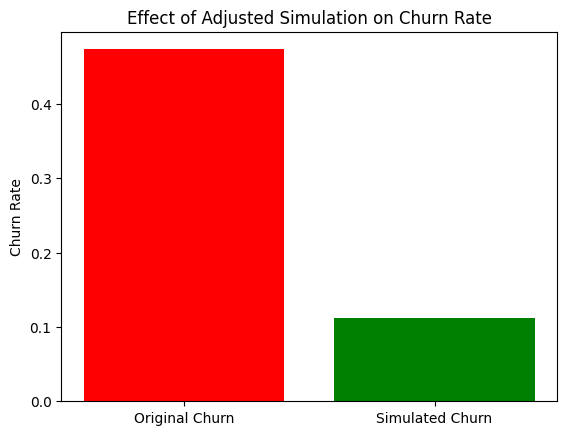

In [ ]:
import matplotlib.pyplot as plt

# Compare original vs simulated churn rates
original_churn = data['Churn'].mean()
simulated_churn = new_churn_rate

plt.bar(['Original Churn', 'Simulated Churn'], [original_churn, simulated_churn], color=['red', 'green'])
plt.ylabel('Churn Rate')
plt.title('Effect of Adjusted Simulation on Churn Rate')
plt.show()